<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/gan/process_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install Image

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt
import zipfile

In [ ]:
# !pip show numpy
# !pip install --upgrade numpy

Name: numpy
Version: 1.21.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: yellowbrick, xgboost, xarray, wordcloud, torchvision, torchtext, tifffile, thinc, Theano-PyMC, tensorflow, tensorflow-probability, tensorflow-hub, tensorflow-datasets, tensorboard, tables, statsmodels, spacy, sklearn-pandas, seaborn, scs, scipy, scikit-learn, scikit-image, resampy, qdldl, PyWavelets, python-louvain, pystan, pysndfile, pymc3, pyerfa, pyemd, pycocotools, pyarrow, plotnine, patsy, pandas, osqp, opt-einsum, opencv-python, opencv-contrib-python, numexpr, numba, nibabel, netCDF4, moviepy, mlxtend, mizani, missingno, matplotlib, matplotlib-venn, lightgbm, librosa, Keras-Preprocessing, kapre, jpeg4py, jaxlib, jax, imgaug, imbalanced-learn, imageio, hyperopt, holoviews, h5py, gym, gensim, folium, fix-yahoo-f

In [9]:
# Mount google drive to colab. need run for every session

from google.colab import drive
drive.mount('/content/drive')
# drive._mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

# change working directory
%cd /content/drive/MyDrive/capstone/
!ls -lart

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/capstone
total 1301523
-rw------- 1 root root  37238932 Mar 19 05:46 cryptopunks.npz
-rw------- 1 root root 282758921 Mar 19 05:51 mutant-ape-yacht-club.npz
drwx------ 2 root root      4096 Mar 19 05:52 output
-rw------- 1 root root 596218972 Mar 19 06:02 meebits.npz
-rw------- 1 root root  20158192 Mar 21 02:24 cryptopunks32.npz
-rw------- 1 root root 214257622 Mar 21 11:22 hapeprime32.npz
drwx------ 2 root root      4096 Mar 26 16:05 generator
drwx------ 2 root root      4096 Apr  3 15:31 boredapeyachtclub
-rw------- 1 root root 182112601 Apr  3 15:38 boredapeyachtclub.npz


In [ ]:
# import boto3  # AWS Python SDK

# # When running on SageMaker, need execution role
# from sagemaker import get_execution_role
# role = get_execution_role()

# # Declare bucket name, remote file, and destination
# bucket = 'nf2-assets'
# subfolder = 'azuki'
# orig_file = 'azuki/azuki_archive.zip'  # full path to file
# dest_file = 'local/path/to/file.p'

# # Connect to S3 bucket and download file
# s3 = boto3.resource('s3')
# s3.Bucket(bucket).download_file(orig_file, dest_file)

# # Connect to S3 bucket and list a folder
# conn = boto3.client('s3')
# contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
# for f in contents:
#     print(f['Key'])

# # Connect to S3 bucket and load a pickle file
# import pickle
# s3client = boto3.client('s3')
# response = s3client.get_object(Bucket=bucket, Key=orig_file)
# body = response['Body']
# data = pickle.loads(body.read())

# # Connect to S3 bucket and read a csv file
# import pandas as pd
# data_location = 's3://{}/{}'.format(bucket, orig_file)
# # data_location = 's3://nf2-assets/azuki/azuki_archive.zip'
# pd.read_csv(data_location)

# # Connect to S3 bucket and read a zip file
# zip_ref = zipfile.ZipFile(data_location,"r")

### Preparing the image dataset: convert to NumPy arrays and store for later use

load and preprocess the images. store the processed file as a binary. This way we can simply reload the processed training data and quickly use it. 

In [3]:
def prepareImages(sourcedir, outputname, result_imgshape):
  start = time.time()

  training_data = []  
  imgfiles   = np.sort(os.listdir(sourcedir))
  for filename in tqdm(imgfiles):      
      path = os.path.join(sourcedir,filename)
      try: 
        image = Image.open(path).resize(result_imgshape[:2], Image.ANTIALIAS).convert('RGB')
        training_data.append(np.asarray(image))
      except: #skip bad images
        pass      
  
  training_data = np.reshape(training_data,(-1, result_imgshape[0], result_imgshape[1], result_imgshape[2]))
  training_data = training_data.astype(np.float32)
  # Normalize the images to [-1, 1]
  training_data = training_data / 127.5 - 1.
  # rescales the image pixels to [0,1] because the RGB pixel scale for images is from 1–255
  # training_data = training_data / 255

  # Saving training image binary
  outputfile = outputname + ".npz"  # size much smaller than .npy
  np.savez_compressed(outputfile, training_data)
  
  print (f'Image preprocess time: {hms_string(time.time()-start)}')

  return outputfile, training_data

def unzip(filename, targetdir):   
  with zipfile.ZipFile(filename,"r") as zip_ref:
    zip_ref.extractall(targetdir)
  return targetdir

# scale image from [-1,1] to [0,255] for display
def rescale_image(imagedata): 
  images = (imagedata + 1) * 127.5
  images = images.astype(np.int32)
  return images

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

def plot_images(imgs, grid_size = 5):
    """
    plot images in a nxn grid
    imgs: vector containing all the numpy images
    grid_size: nxn grid containing images
    """     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")
 
    for i in range(1, columns*rows+1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

def fixBadZipfile(zipFile):  
    f = open(zipFile, 'r+b')  
    data = f.read()  
    pos = data.find('\x50\x4b\x05\x06') # End of central directory signature  
    if (pos > 0):  
        self._log("Trancating file at location " + str(pos + 22)+ ".")  
        f.seek(pos + 22)   # size of 'ZIP end of central directory record' 
        f.truncate()  
        f.close()  
    else:  
     # raise error, file is truncated
        print("file is truncated")

In [4]:
# unzip if needed
image_dir = unzip('boredapeyachtclub_archive.zip', 'boredapeyachtclub')
# image_dir = unzip('meebits_archive.zip', 'meebits')

# unzip('generator.zip', 'generator')
# unzip('discriminator.zip', 'discriminator')

In [5]:
# prepare image data
image_dir ='boredapeyachtclub'
result_imgshape = (128, 128, 3)   # (32, 32, 3)

outputfile, training_data = prepareImages(image_dir, image_dir, result_imgshape)  # 0:06:42.82
# np.savez_compressed('boredapeyachtclub.npz', training_data)

100%|██████████| 9900/9900 [00:19<00:00, 510.24it/s]


Image preprocess time: 0:00:55.66


### Test image data
load generated image binary file, spot check data and display images

In [11]:
# check result
# image_data = np.load('cryptopunks32.npz')['arr_0']  # (10000, 32, 32, 3)
# image_data = np.load('cryptopunks.npz')['arr_0']

# image_data = np.load('mutant-ape-yacht-club.npz')['arr_0']  # (10050, 128, 128, 3)
# image_data = np.load('meebits.npz')['arr_0']  # (19798, 128, 128, 3)
# image_data = np.load('hapeprime32.npz')['arr_0']
# image_data = np.load('hapeprime.npz')['arr_0']  #(81920, 128, 128, 3)
image_data = np.load('boredapeyachtclub.npz')['arr_0']  #(9900, 128, 128, 3)

image_data.shape
# image_data[0][0][0][0], image_data[0][0][0][1], image_data[0][0][0][2]

(9900, 128, 128, 3)

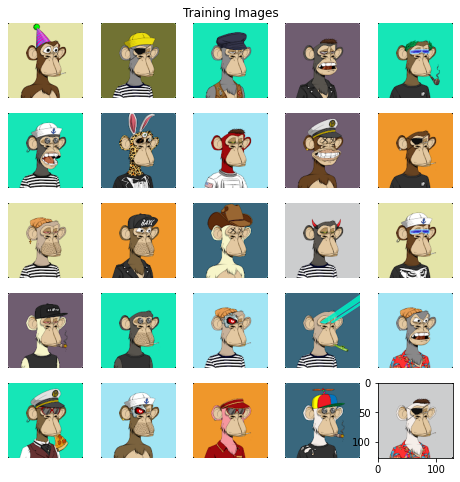

In [12]:
# scale data back to [0, 255] for display
images = rescale_image(image_data)
# images[0][0][0][0], images[0][0][0][1], images[0][0][0][2]

plot_images(images[:50])